In [ ]:
pip install scanpy

In [ ]:
pip install leidenalg

In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
filename = '.../20200917_MGH_Broad_Villani_to_CZI.h5ad'
ann = sc.read(filename, backed=None, sheet=None, ext=None, delimiter=None, first_column_names=False, backup_url=None, cache=False)

Filter COVID19 cases - D0

In [6]:
#Covid dataset
ann = ann[ann.obs["covid"] == 1, :]

ann = ann[ann.obs["time_point"] == 'D0', :]


Select KITLG high protein expression levels patients

In [7]:
ann = ann[ann.obs["patient_id"].isin([144, 345, 367, 370]) , :]

In [8]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=90, facecolor='white')

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.9.6 pynndescent==0.5.4


normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


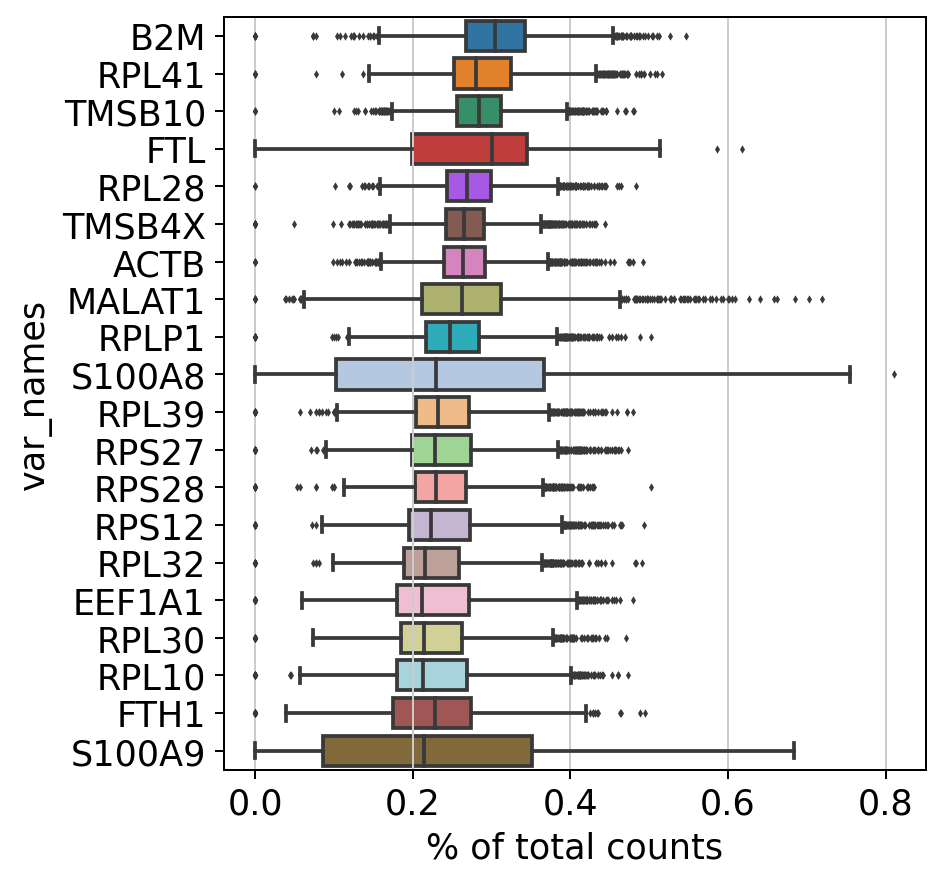

In [9]:
sc.pl.highest_expr_genes(ann, n_top=20, )

In [10]:
sc.pp.filter_cells(ann, min_genes=200)
sc.pp.filter_genes(ann, min_cells=3)

filtered out 8163 genes that are detected in less than 3 cells


In [11]:
ann.var['mt'] = ann.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(ann, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

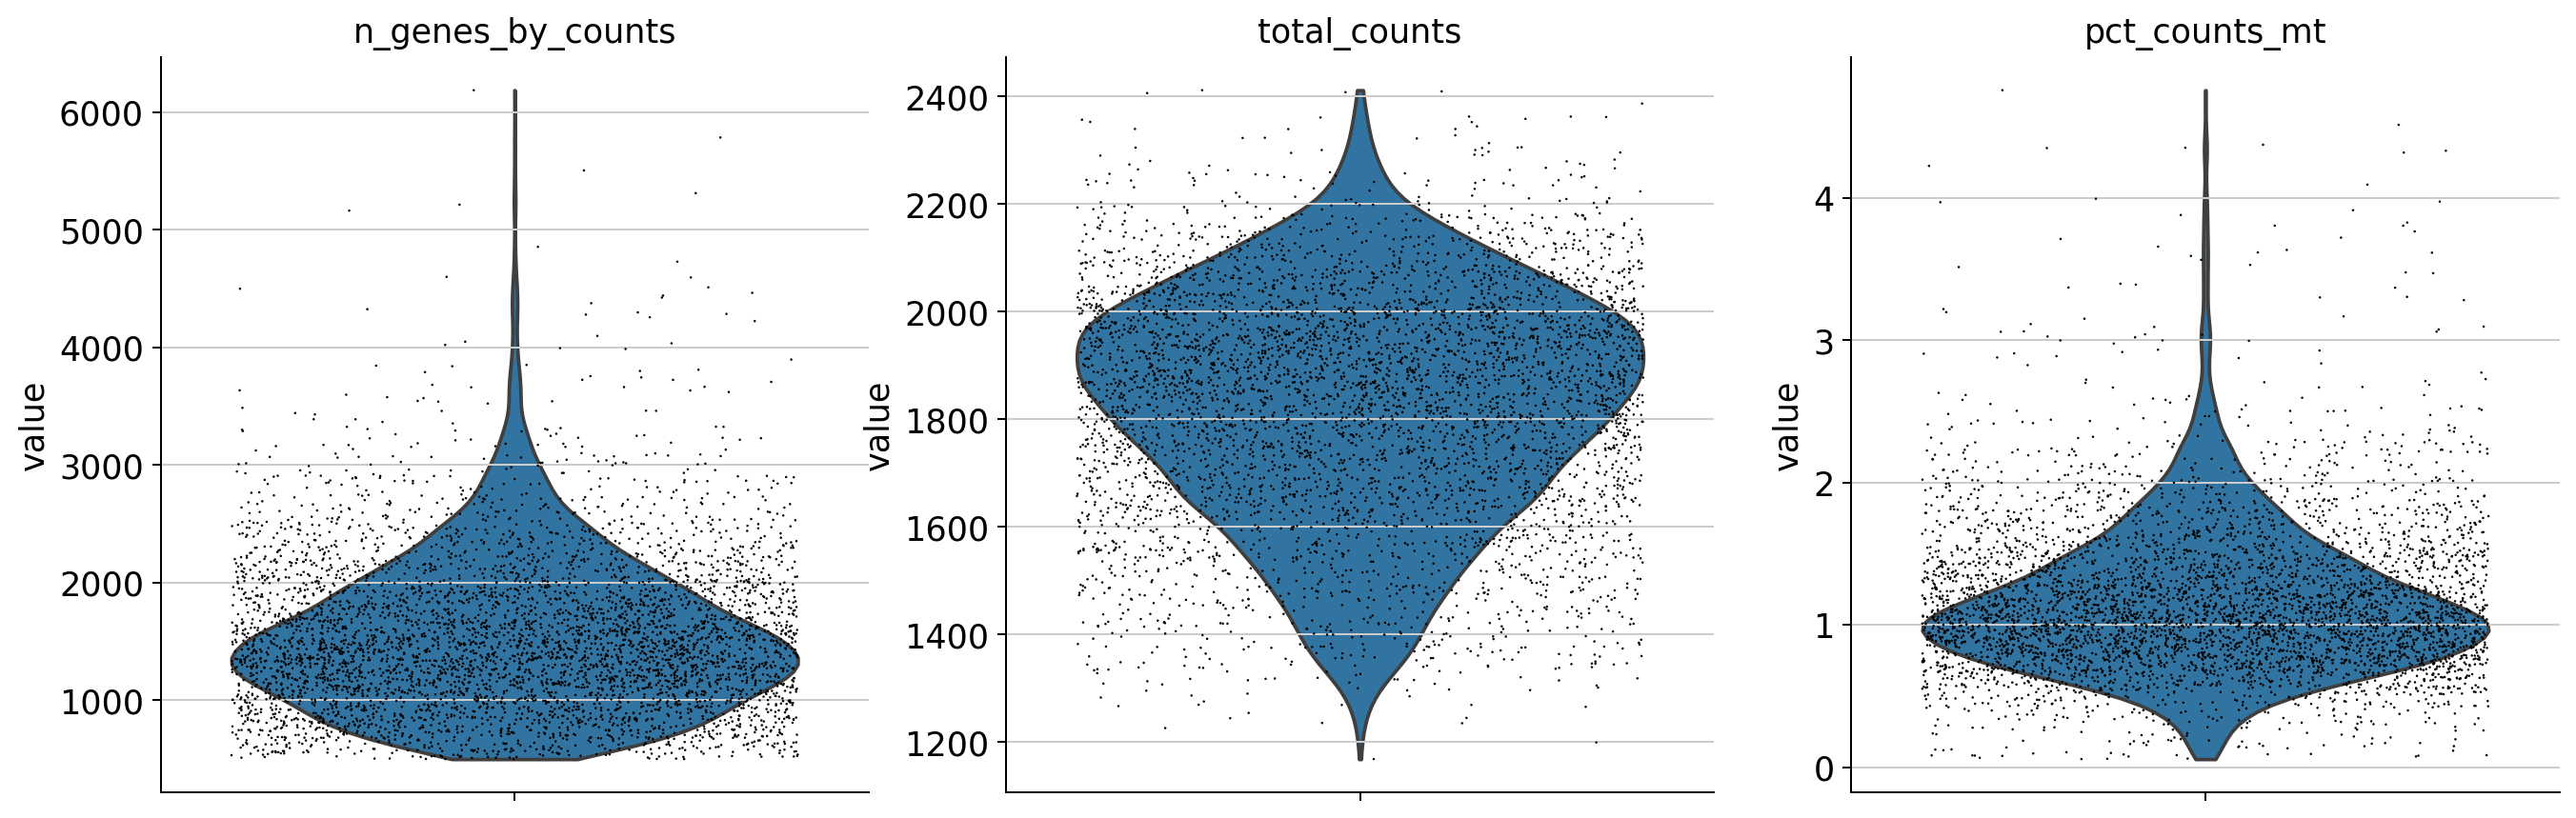

In [12]:
sc.pl.violin(ann, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

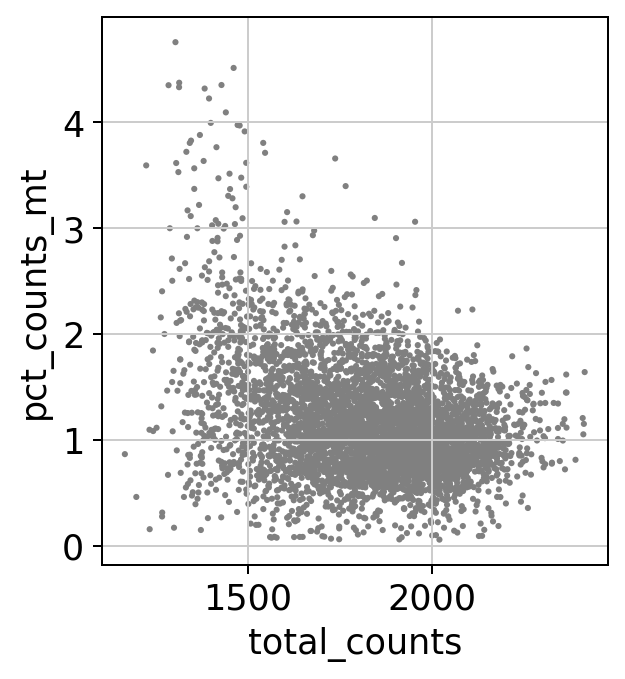

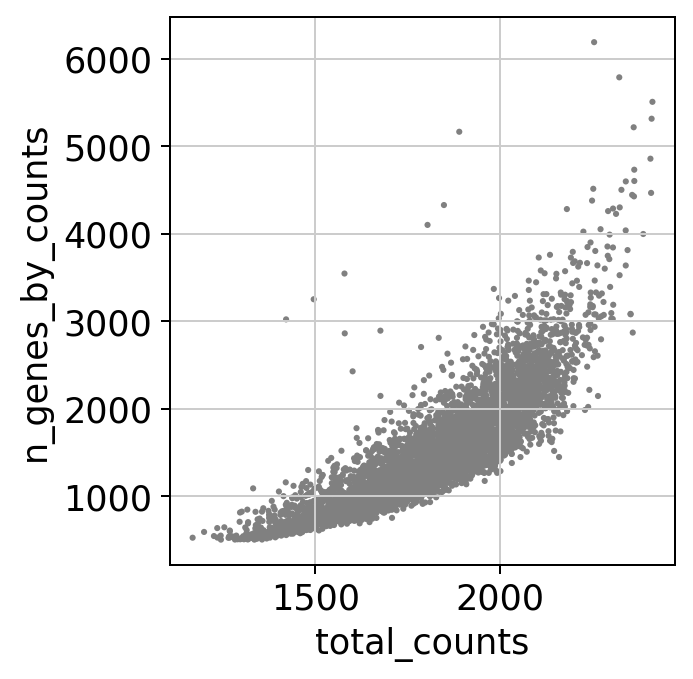

In [13]:
sc.pl.scatter(ann, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(ann, x='total_counts', y='n_genes_by_counts')

In [14]:
ann = ann[ann.obs.n_genes_by_counts < 2500, :]
ann = ann[ann.obs.pct_counts_mt < 5, :]

In [15]:
sc.pp.normalize_total(ann, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [16]:
sc.pp.log1p(ann)

In [17]:
sc.pp.highly_variable_genes(ann, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


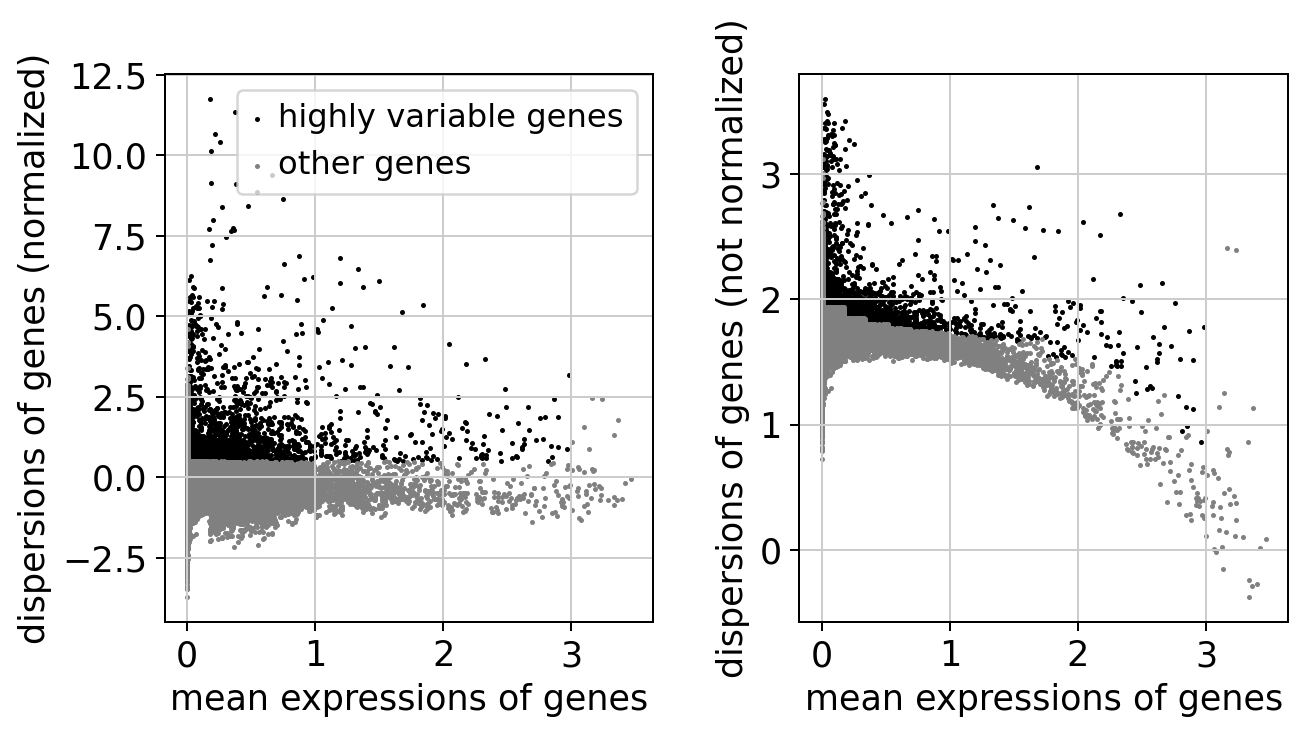

In [18]:
sc.pl.highly_variable_genes(ann)

In [19]:
ann.raw = ann

In [20]:
ann = ann[:, ann.var.highly_variable]

In [21]:
sc.pp.regress_out(ann, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


    finished (0:00:13)


In [22]:
sc.pp.scale(ann, max_value=10)

In [23]:
sc.tl.pca(ann, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


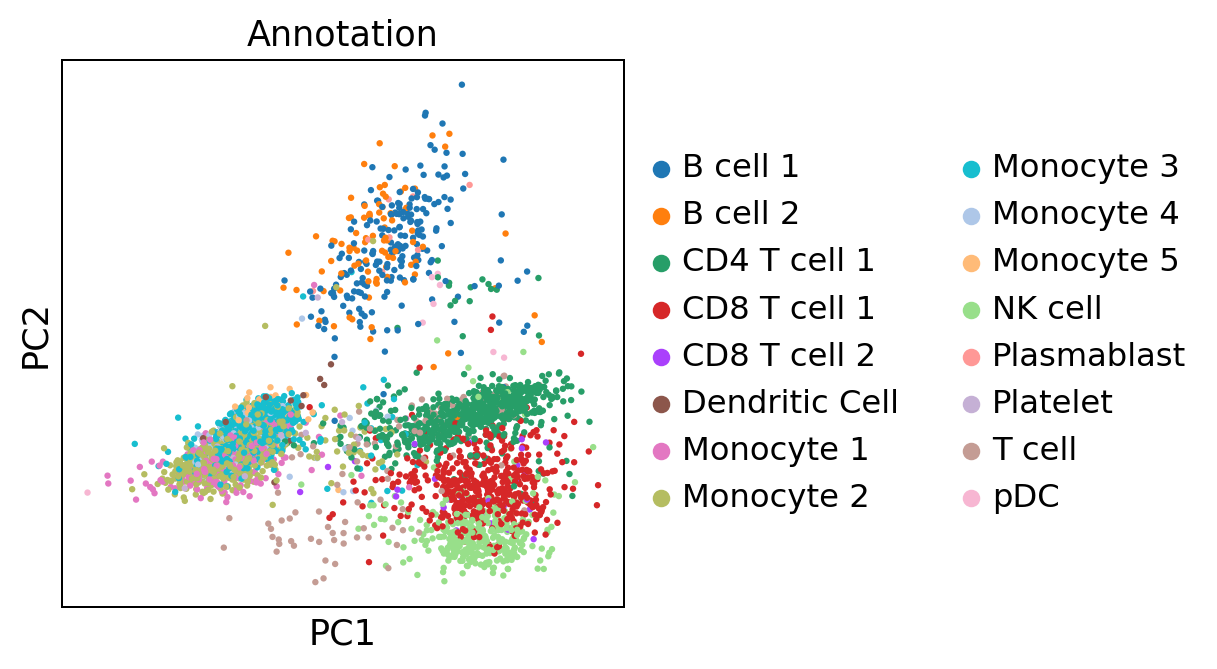

In [24]:
sc.pl.pca(ann, color='Annotation')

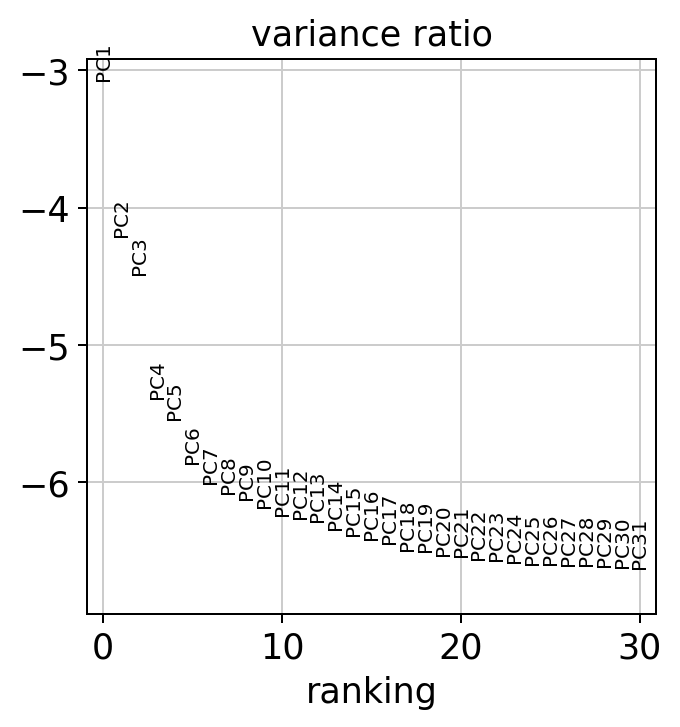

In [25]:
sc.pl.pca_variance_ratio(ann, log=True)

In [26]:
sc.pp.neighbors(ann, n_neighbors=10) 
# , n_neighbors=10, n_pcs=40

computing neighbors
    using 'X_pca' with n_pcs = 50


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [27]:
sc.tl.umap(ann,)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


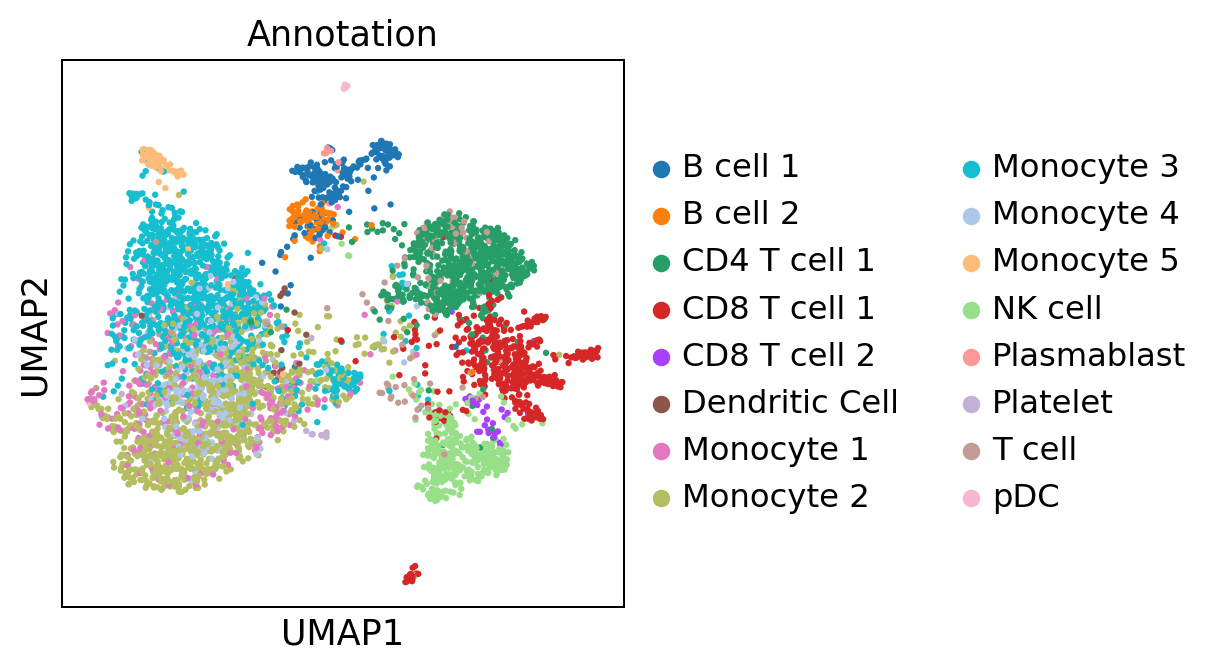

In [28]:
sc.pl.umap(ann, color=[ 'Annotation'], save='SCFHigh.svg')

Clustering the neighborhood graph

In [29]:
sc.tl.leiden(ann)

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


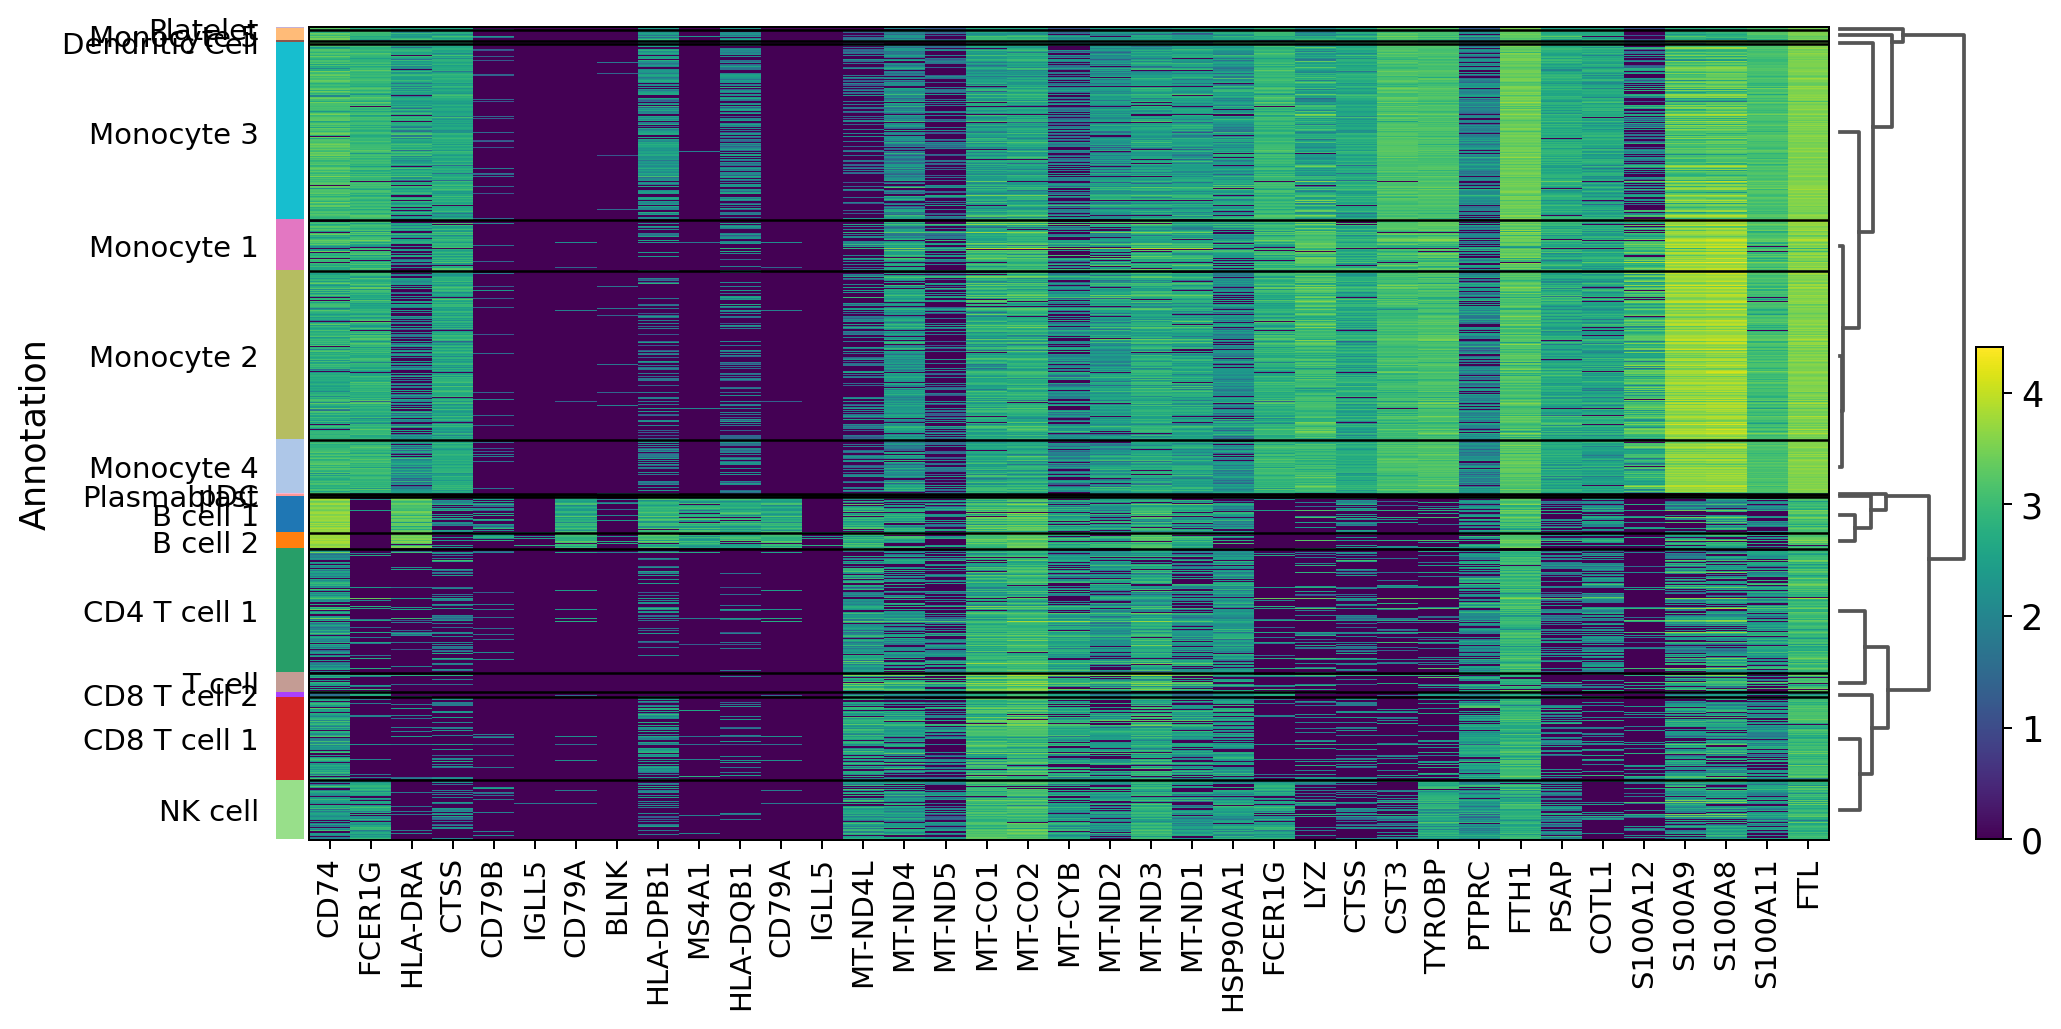

In [31]:
marker_genes = ['CD74','FCER1G','HLA-DRA','CTSS', 'CD79B','IGLL5','CD79A','BLNK','HLA-DPB1','MS4A1','HLA-DQB1', 'CD79A','IGLL5',
                 'MT-ND4L','MT-ND4','MT-ND5','MT-CO1','MT-CO2','MT-CYB','MT-ND2','MT-ND3','MT-ND1', 'HSP90AA1','FCER1G','LYZ','CTSS',
                'CST3','TYROBP','PTPRC','FTH1','PSAP','COTL1','S100A12','S100A9','S100A8','S100A11','FTL']
ax = sc.pl.heatmap(ann, marker_genes, groupby='Annotation', cmap='viridis', dendrogram=True, save='dendrogramhigh.svg')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


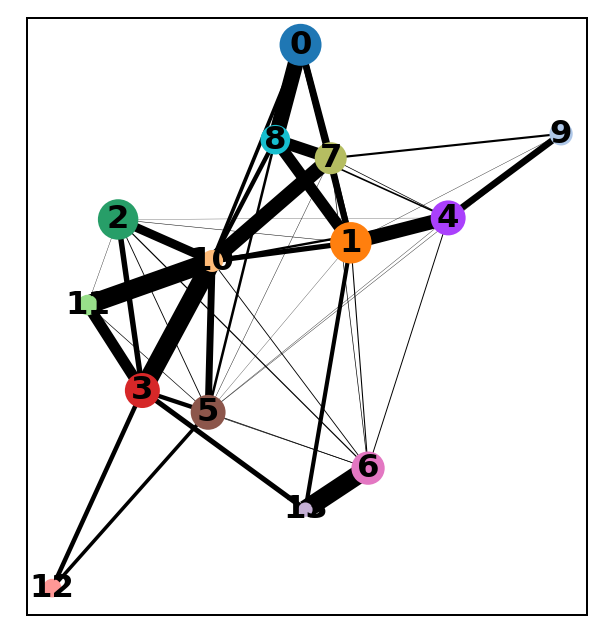

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


In [32]:
sc.tl.paga(ann)
sc.pl.paga(ann, )  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(ann, init_pos='paga' )

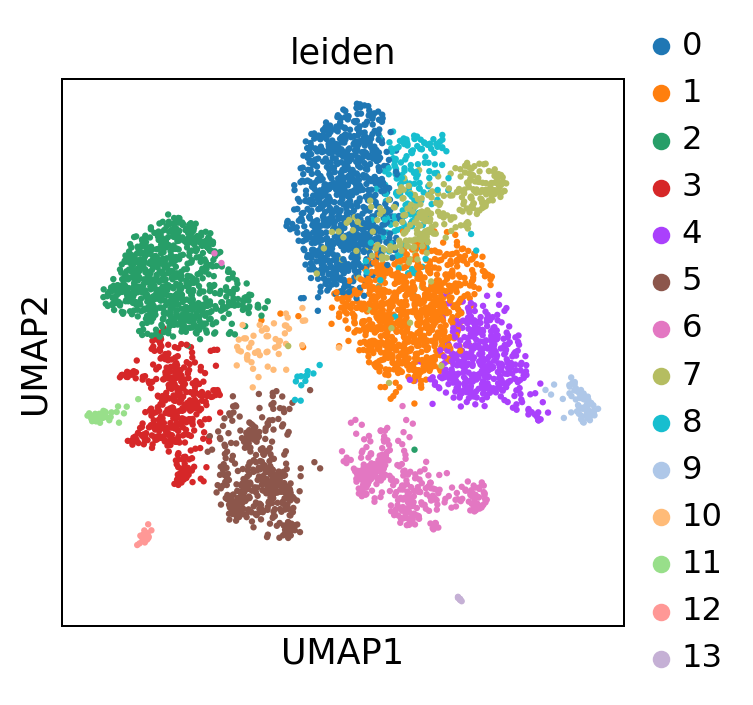

In [33]:
sc.pl.umap(ann, color=['leiden'])

**Finding marker genes**
ranking for the highly differential genes in each cluster

In [34]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:04)


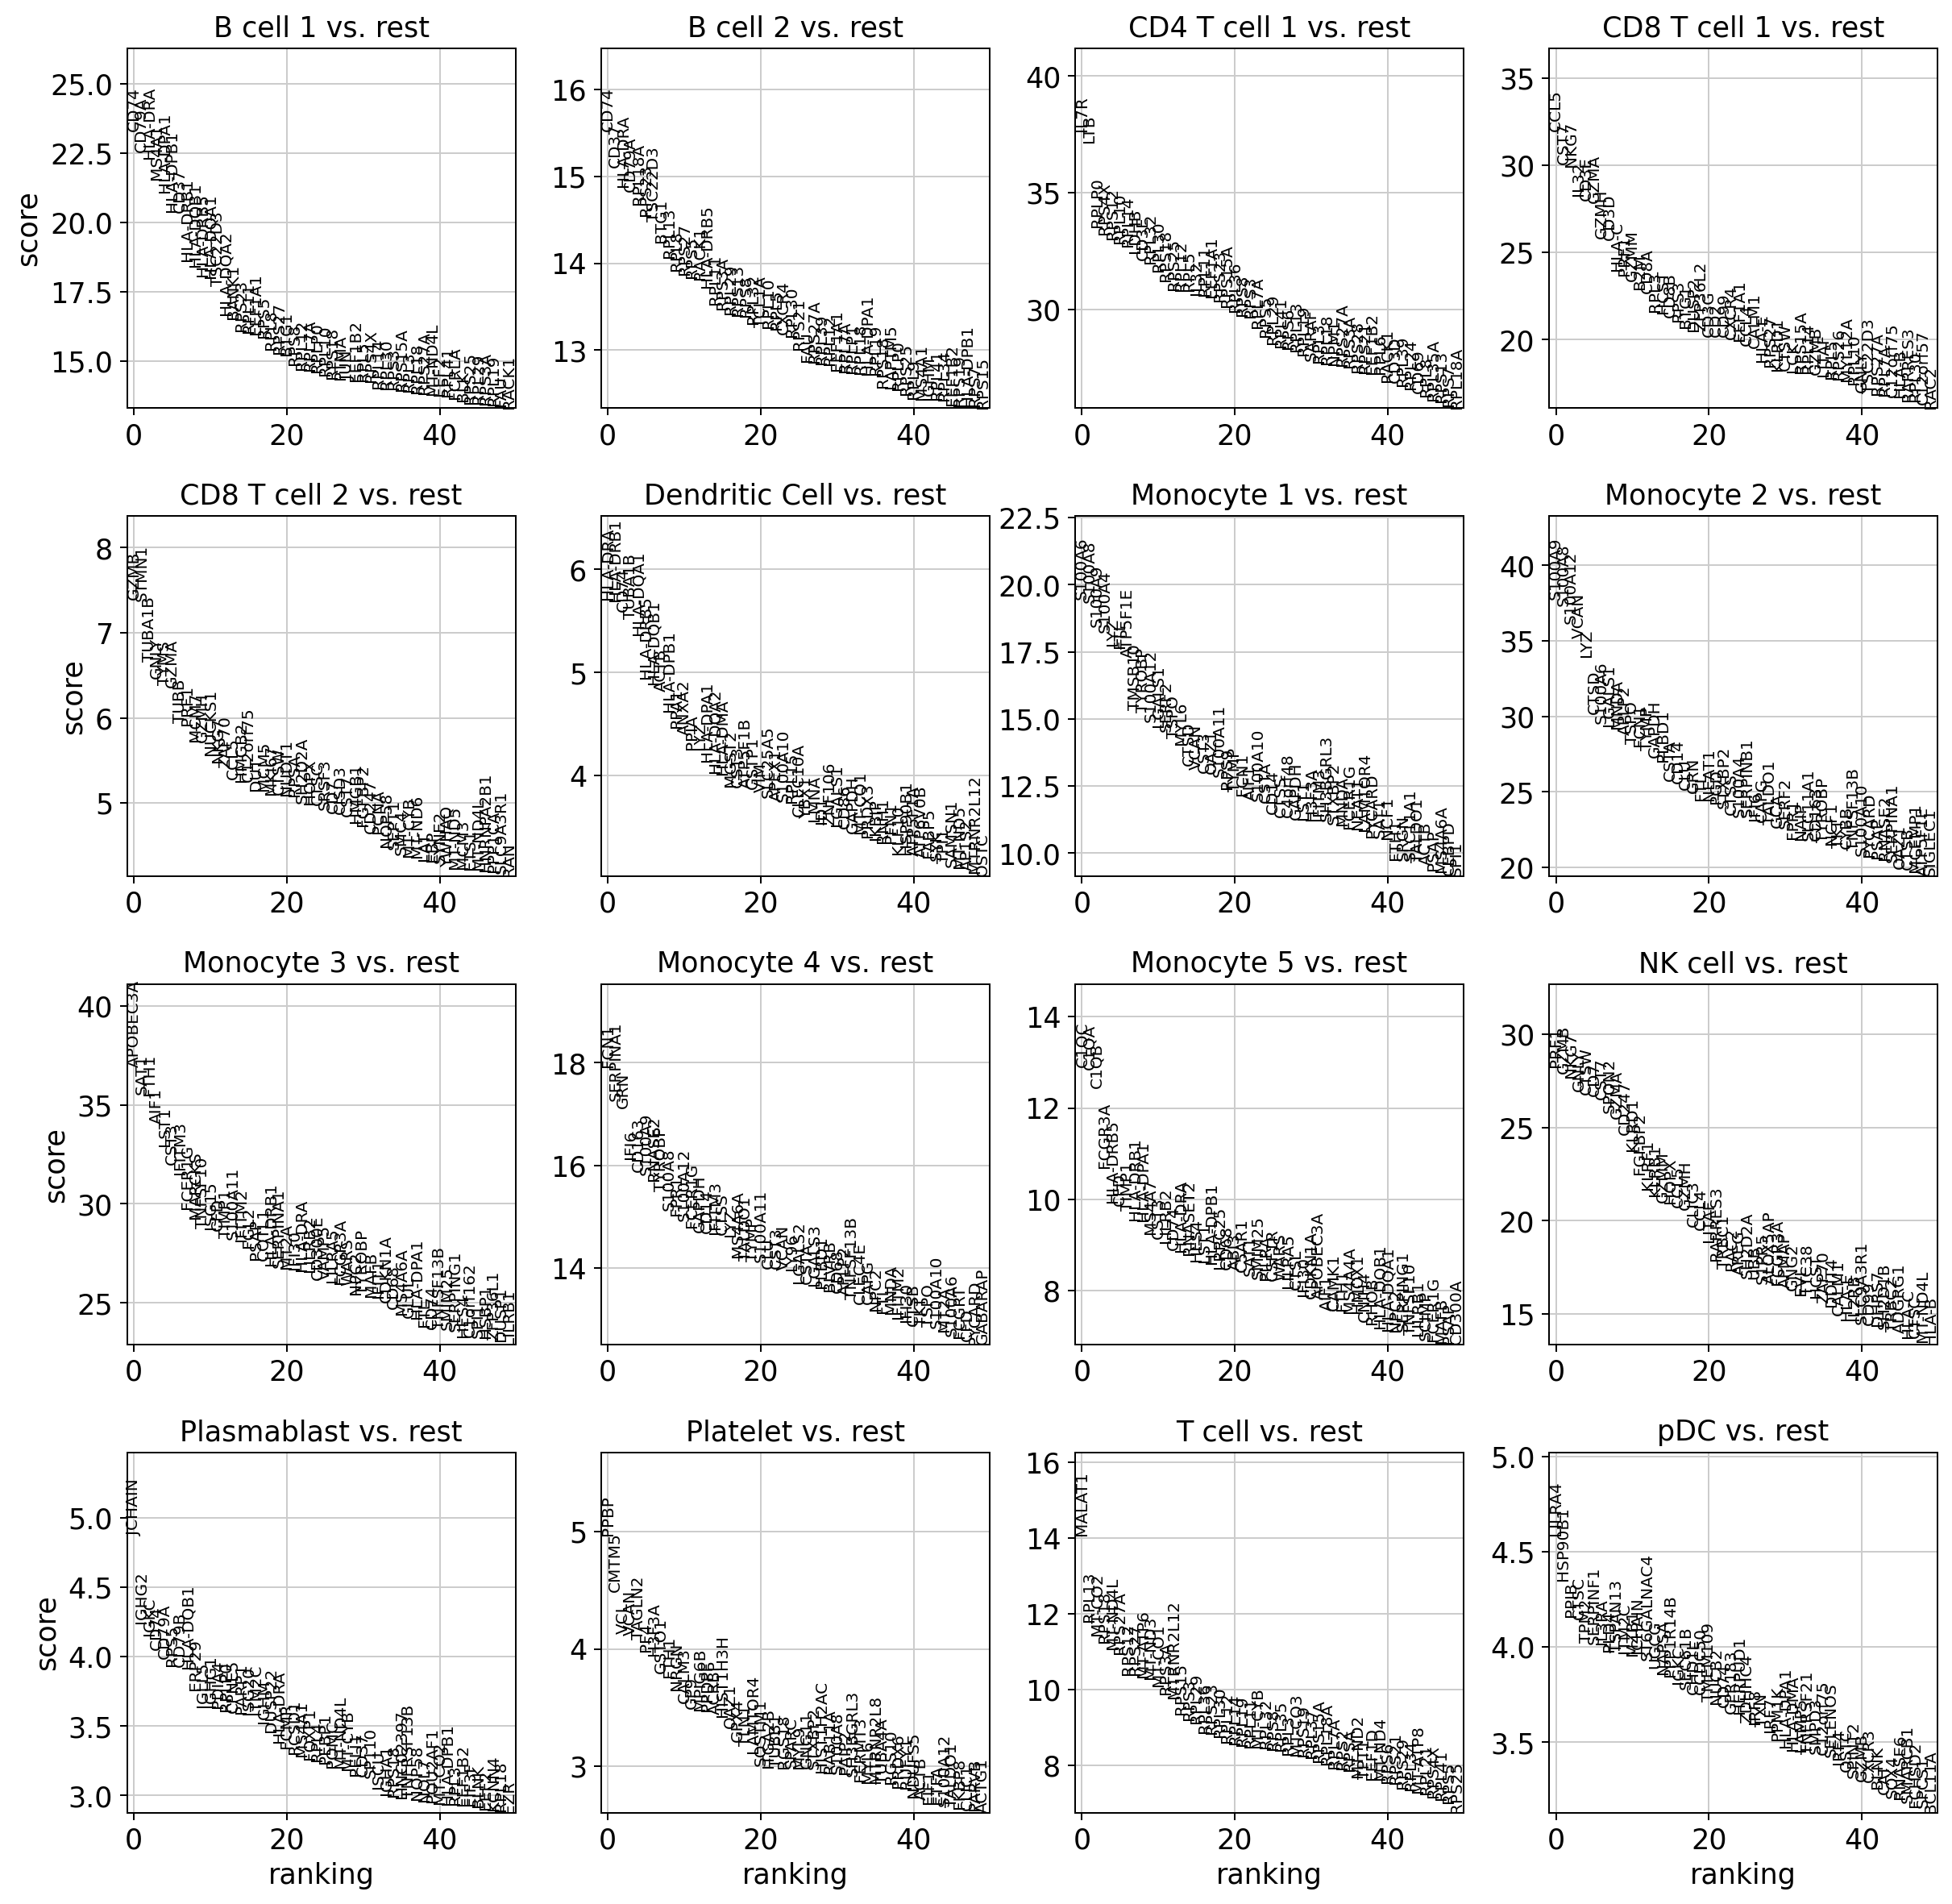

In [35]:
#Wilcoxon rank-sum (Mann-Whitney-U) test

sc.tl.rank_genes_groups(ann, 'Annotation', method='wilcoxon')
sc.pl.rank_genes_groups(ann, n_genes=50, sharey=False)

In [36]:
#10 top ranked genes per cluster

# gene_stinf = pd.DataFrame(ann.uns['rank_genes_groups']['names']).head(50)
rgenes = pd.DataFrame(ann.uns['rank_genes_groups']['names']).head(5)
l_markers = []
for rg in rgenes.columns:
  lrg = rgenes[rg].to_list()
  for g in lrg:
    l_markers.append(g)
l_markers.append('KIT')

In [37]:
result = ann.uns['rank_genes_groups']
groups = result['names'].dtype.names
expr = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals', 'logfoldchanges']})

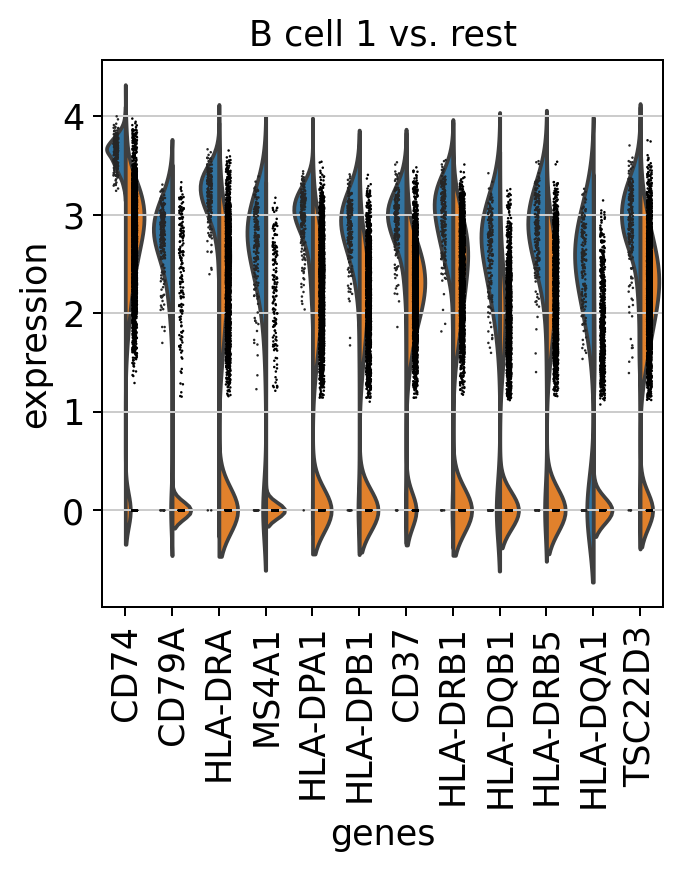

In [39]:
sc.pl.rank_genes_groups_violin(ann, groups='B cell 1', n_genes=12)

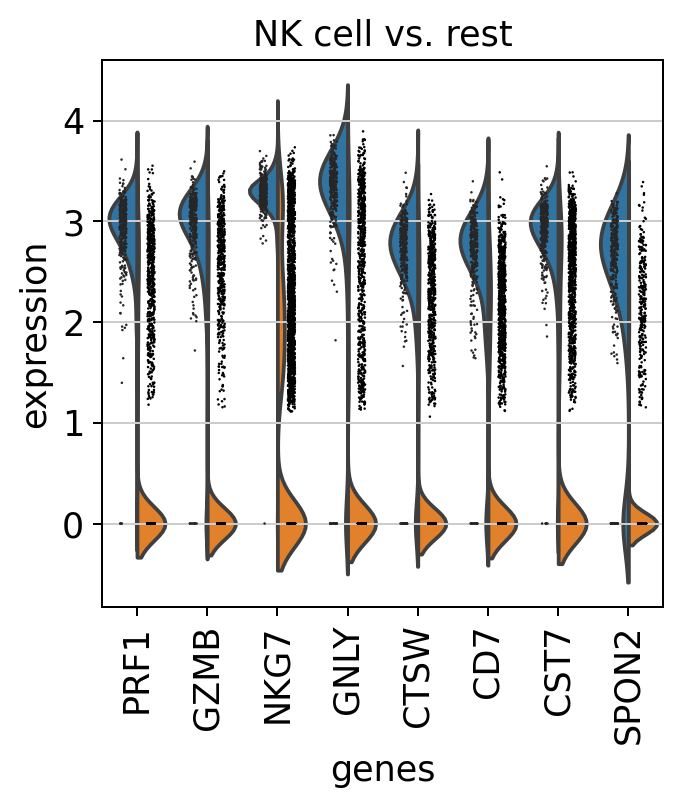

In [40]:
sc.pl.rank_genes_groups_violin(ann, groups='NK cell', n_genes=8)

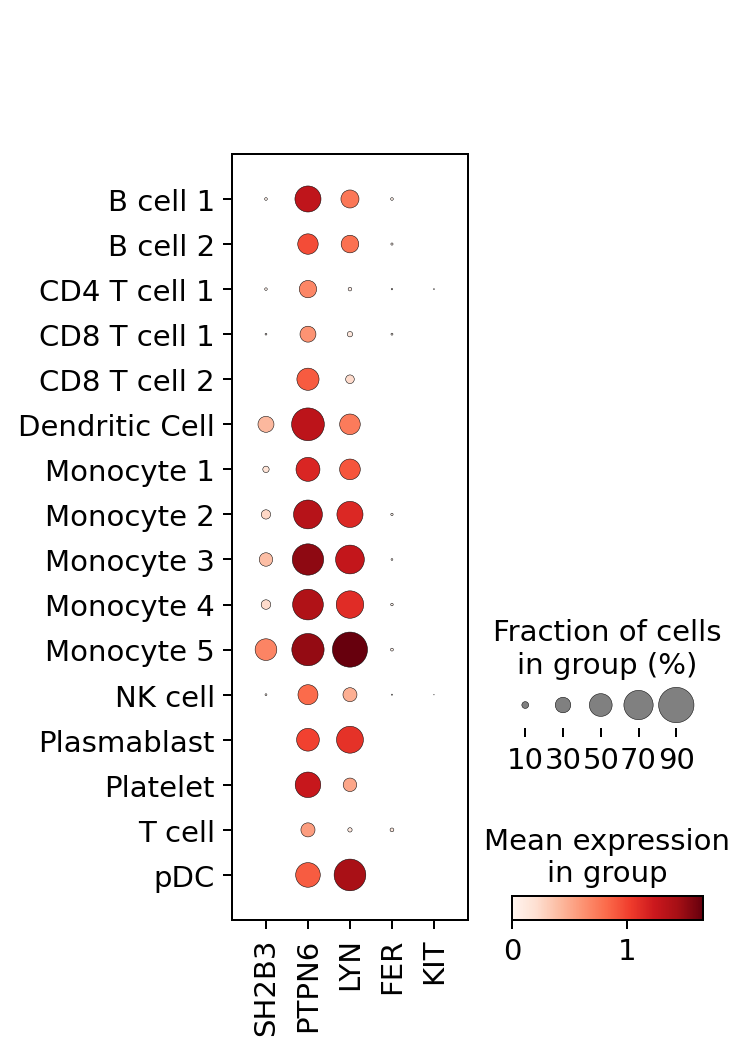

In [42]:
l_markers = ['SH2B3', 'PTPN6', 'LYN', 'FER',  'KIT']
marker_genes = list(dict.fromkeys(l_markers))
sc.pl.dotplot(ann, marker_genes, groupby='Annotation', save='highSCFexphigh.svg')

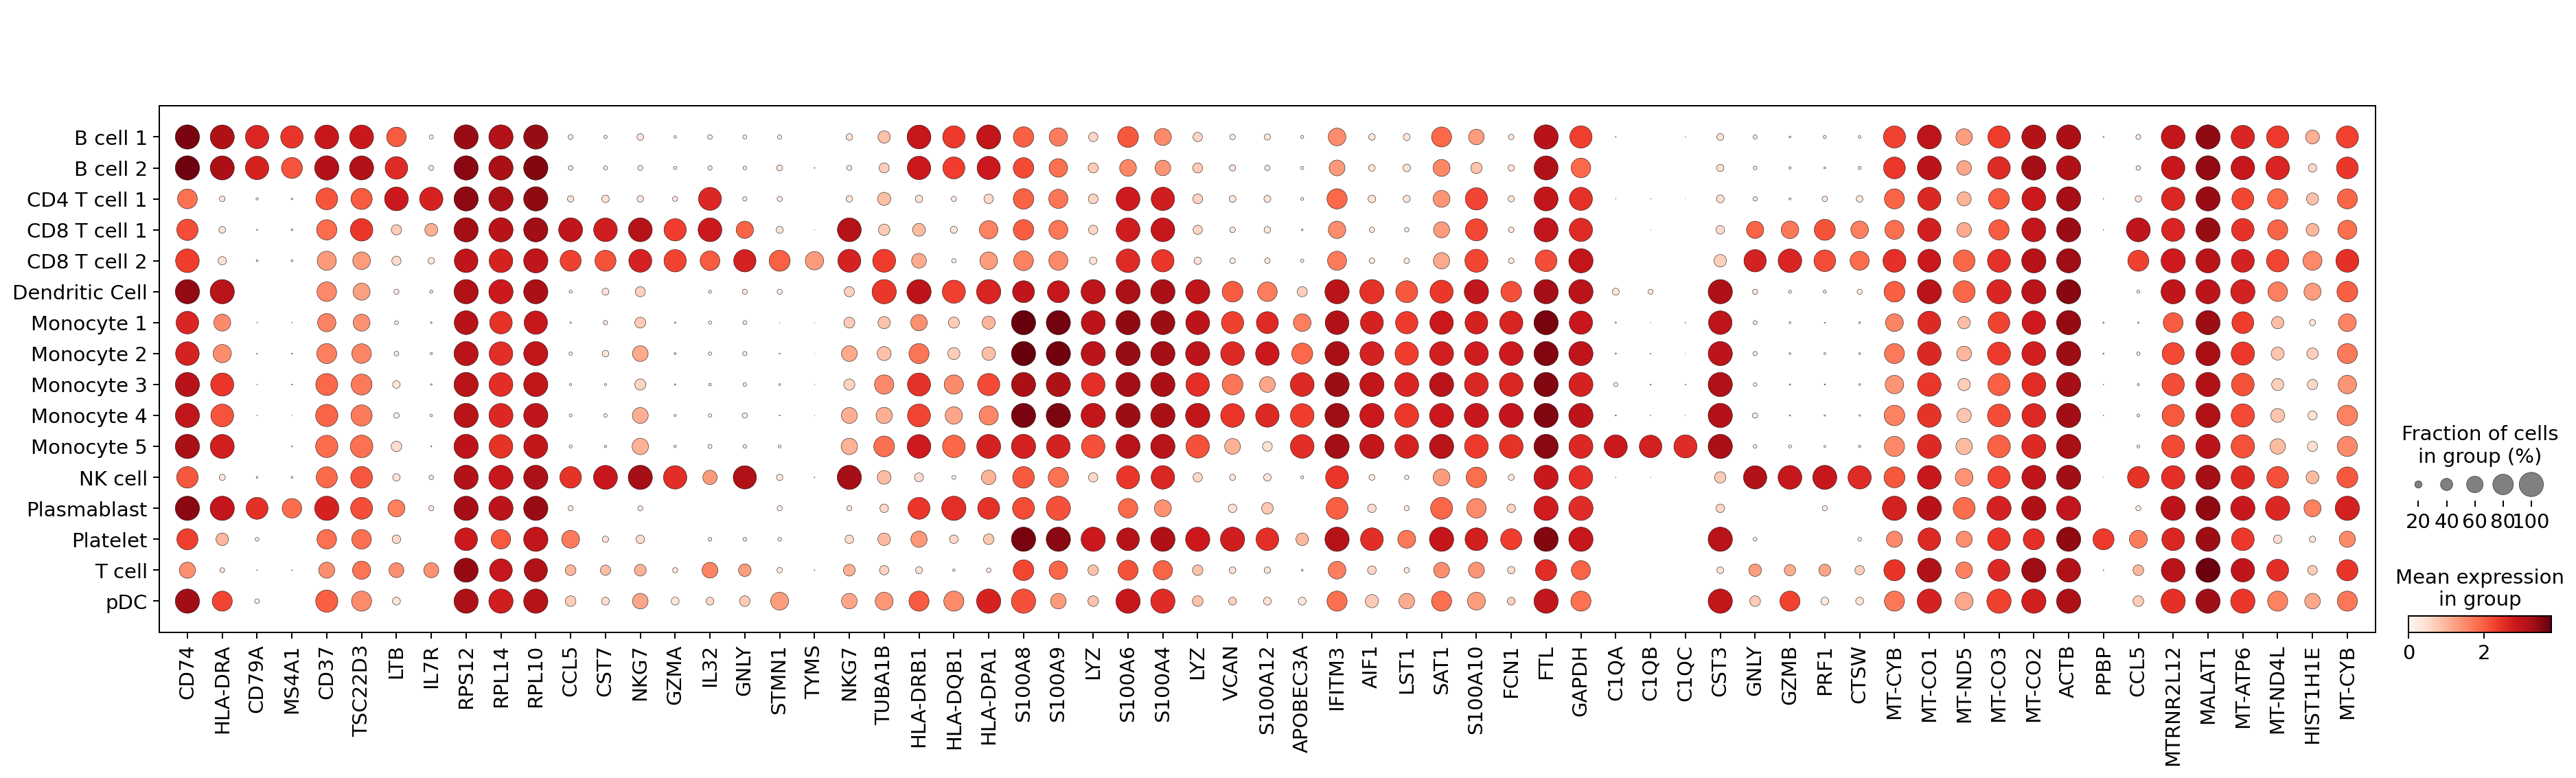

In [44]:
marker_genes = ['CD74', 'HLA-DRA', 'CD79A', 'MS4A1', 'CD37', 'TSC22D3', 'LTB', 'IL7R', 'RPS12', 'RPL14', 'RPL10', 'CCL5', 'CST7', 'NKG7', 'GZMA', 'IL32', 
                'GNLY', 'STMN1', 'TYMS', 'NKG7', 'TUBA1B', 'HLA-DRB1', 'HLA-DQB1', 'HLA-DPA1', 'S100A8', 'S100A9', 'LYZ', 'S100A6', 'S100A4', 'LYZ', 'VCAN', 'S100A12',
                'APOBEC3A', 'IFITM3', 'AIF1', 'LST1', 'SAT1', 'S100A10', 'FCN1', 'FTL', 'GAPDH', 'C1QA', 'C1QB', 'C1QC', 'CST3', 'GNLY', 'GZMB', 'PRF1', 'CTSW',
                'MT-CYB', 'MT-CO1', 'MT-ND5', 'MT-CO3', 'MT-CO2', 'ACTB', 'PPBP', 'CCL5', 'MTRNR2L12', 'MALAT1', 'MT-ATP6', 'MT-ND4L', 'HIST1H1E', 'MT-CYB']
sc.pl.dotplot(ann, marker_genes, groupby='Annotation')

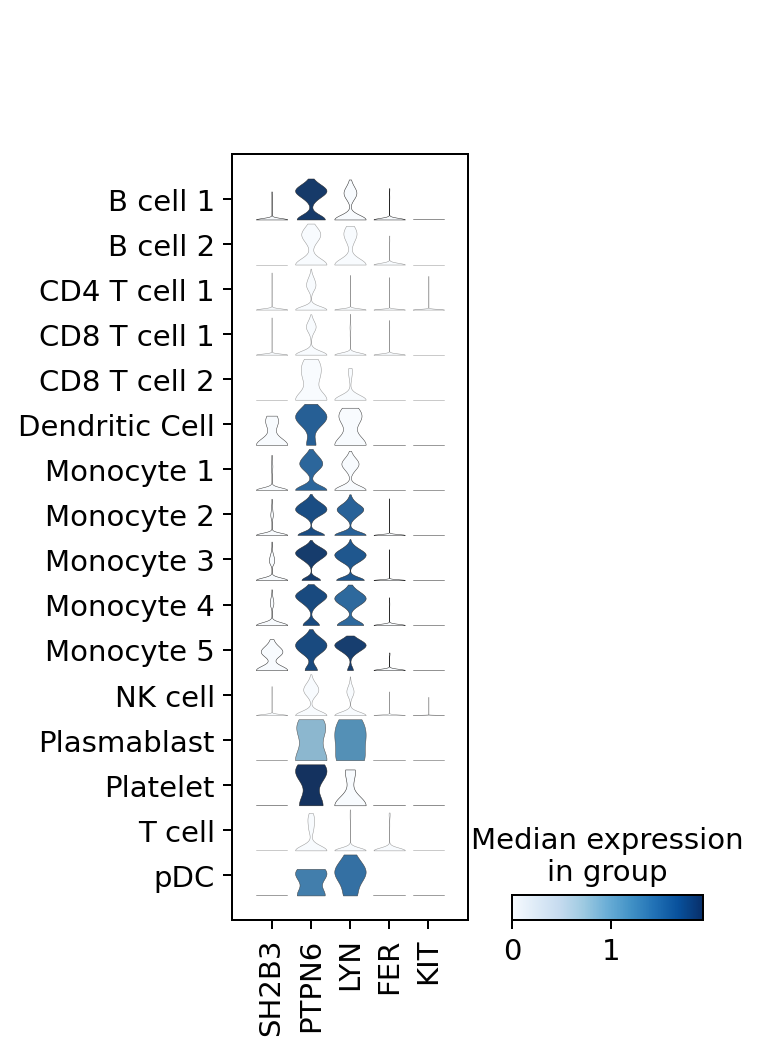

In [43]:
sc.pl.stacked_violin(ann, marker_genes, groupby='Annotation', rotation=90, save='scf_high.svg')